In [1]:
import copy
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import time

from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as tt

from matplotlib import pyplot as plt

from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder

In [2]:
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'
print('Using', DEVICE)

DATA_FOLDER = 'data/'
CLASSES = ['engraving', 'iconography', 'painting', 'sculpture']
MODELS = ['simplenet', 'resnet', 'alexnet', 'vgg']
BATCH_SIZE = 16

sns.set()
sns.set_style("whitegrid")

Using cuda


## Data

In [3]:
class MapDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        if self.map:     
            x = self.map(self.dataset[index][0]) 
        else:     
            x = self.dataset[index][0]
        y = self.dataset[index][1]  
        return x, y

    def __len__(self):
        return len(self.dataset)

In [4]:
transforms = tt.Compose([
    tt.Resize((224, 224)),
    tt.ToTensor(),
    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_transforms = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomRotation(30),
    tt.Resize((224, 224)),
    tt.ToTensor(),
    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageFolder(DATA_FOLDER)
test_len = int(len(dataset)*0.2)
train_set, val_set, test_set = random_split(dataset, [len(dataset)-test_len*2, test_len, test_len])

train_loader = DataLoader(MapDataset(train_set, train_transforms), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(MapDataset(val_set, transforms), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(MapDataset(test_set, transforms), batch_size=BATCH_SIZE, shuffle=True)

In [49]:
stats = [0]*4
for i in range(len(dataset)):
    stats[dataset[i][1]] += 1

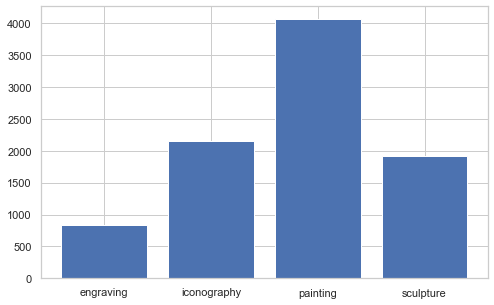

In [50]:
plt.figure(figsize=(8,5))
plt.bar(CLASSES, stats)
plt.gcf().savefig('stats')

## Training functions

In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10, is_inception=False):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            
            index = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if (100 * index // len(dataloaders[phase])) // 10 != (100 * (index - 1) // len(dataloaders[phase])) // 10:
                    print('=', end='')
                index += 1
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('\t{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [6]:
def plot_history(history, path):
    plt.figure(figsize=(8,7))
    plt.plot(history)
    plt.gcf().savefig(path)
    plt.show()

In [7]:
def plot_confusion_matrix(target, probs, path):
    predicted = [np.argmax(probs[i]) for i in range(len(probs))]
    cmat = confusion_matrix(target, predicted)
    plt.figure(figsize=(7,7))
    sns.heatmap(
        cmat / np.sum(cmat, axis=1),
        annot=True, cbar=False,
        xticklabels=CLASSES,
        yticklabels=CLASSES)
    plt.ylabel("true")
    plt.xlabel("predicted")
    plt.gcf().savefig(path)
    plt.show()

In [8]:
def test_model(model, loader, path):
    model.eval()
    running_corrects = 0
    total_number = 0
    
    predicted = []
    target = []
    
    for i, (inputs, labels) in enumerate(loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        total_number += inputs.size(0)
        
        target += labels.to('cpu').tolist()
        predicted += outputs.to('cpu').tolist()

    accuracy = running_corrects.double() / total_number
    plot_confusion_matrix(target, predicted, path)
    
    return accuracy

## Simple neural network

In [9]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq_1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True),
            nn.Conv2d(8, 16, kernel_size=(3, 3)),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Dropout(0.2)
        )
        self.seq_2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True),
            nn.Conv2d(16, 32, kernel_size=(3, 3)),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Dropout(0.2)
        )
        self.seq_3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True),
            nn.Conv2d(32, 64, kernel_size=(3, 3)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Dropout(0.5)
        )
        self.seq_4 = nn.Sequential(
            Flatten(),
            nn.Linear(36864, 1000, bias=True),
            nn.BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True),
            nn.Dropout(0.4),
            nn.Linear(1000, 4, bias=True),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.seq_1(x)
        x = self.seq_2(x)
        x = self.seq_3(x)
        x = self.seq_4(x)
        return x

simplenet = SimpleNet().to(DEVICE)

Epoch 0/9
==========	train Loss: 1.2229 Acc: 0.5123
==========	val Loss: 1.1435 Acc: 0.5905

Epoch 1/9
==========	train Loss: 1.1612 Acc: 0.5749
==========	val Loss: 1.1858 Acc: 0.5499

Epoch 2/9
==========	train Loss: 1.1323 Acc: 0.6048
==========	val Loss: 1.1349 Acc: 0.5989

Epoch 3/9
==========	train Loss: 1.1227 Acc: 0.6132
==========	val Loss: 1.0769 Acc: 0.6596

Epoch 4/9
==========	train Loss: 1.1159 Acc: 0.6202
==========	val Loss: 1.1135 Acc: 0.6223

Epoch 5/9
==========	train Loss: 1.0925 Acc: 0.6451
==========	val Loss: 1.1337 Acc: 0.6006

Epoch 6/9
==========	train Loss: 1.1000 Acc: 0.6397
==========	val Loss: 1.2627 Acc: 0.4741

Epoch 7/9
==========	train Loss: 1.1289 Acc: 0.6113
==========	val Loss: 1.0853 Acc: 0.6552

Epoch 8/9
==========	train Loss: 1.0812 Acc: 0.6587
==========	val Loss: 1.0424 Acc: 0.6964

Epoch 9/9
==========	train Loss: 1.0736 Acc: 0.6659
==========	val Loss: 1.0679 Acc: 0.6713

Training complete in 26m 51s
Best val Acc: 0.696379


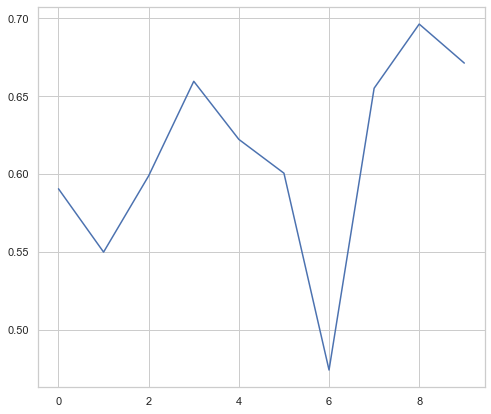

In [10]:
if 'simplenet' in MODELS:
    optimizer = torch.optim.Adam(simplenet.parameters())
    criterion = nn.CrossEntropyLoss()
    simplenet, simplenet_history = train_model(simplenet, {'train': train_loader, 'val': val_loader}, criterion, optimizer)
    torch.save(simplenet.state_dict(), 'simplenet.pth')
    plot_history(simplenet_history, 'simplenet')

In [11]:
simplenet.load_state_dict(torch.load('simplenet.pth'))

<All keys matched successfully>

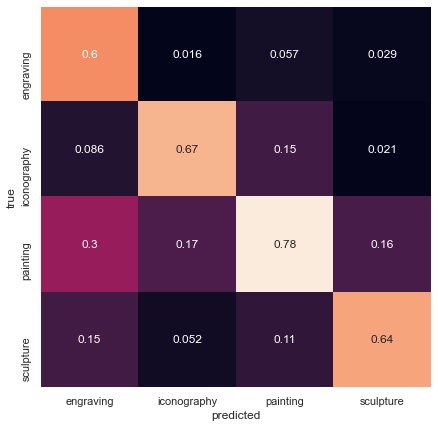

tensor(0.7053, device='cuda:0', dtype=torch.float64)

In [12]:
test_model(simplenet, test_loader, 'simplenet_cmat')

## Transfer learning

In [14]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [15]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [18]:
model, inp = initialize_model('resnet', 4, True, True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
for model_name in MODELS:
    if model_name == 'simplenet':
        continue
    model, input_size = initialize_model(model_name, len(CLASSES), True, use_pretrained=True)
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    model, model_history = train_model(model, {'train': train_loader, 'val': val_loader}, criterion, optimizer)
    torch.save(model.state_dict(), model_name + '.pth')
    plot_history(model_history, model_name)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to C:\Users\Daria/.cache\torch\hub\checkpoints\vgg11-bbd30ac9.pth
4.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

46.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

54.3%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_ms

Epoch 0/9
==========	train Loss: 0.3759 Acc: 0.8572
==========	val Loss: 0.2372 Acc: 0.9198

Epoch 1/9
==========	train Loss: 0.3037 Acc: 0.8860
==========	val Loss: 0.2309 Acc: 0.9237

Epoch 2/9
==========	train Loss: 0.2951 Acc: 0.8953
==========	val Loss: 0.2447 Acc: 0.9142

Epoch 3/9
==========	train Loss: 0.2678 Acc: 0.9032
==========	val Loss: 0.2090 Acc: 0.9248

Epoch 4/9
==========	train Loss: 0.2766 Acc: 0.9049
==========	val Loss: 0.2412 Acc: 0.9136

Epoch 5/9
==========	train Loss: 0.2744 Acc: 0.9045
==========	val Loss: 0.2163 Acc: 0.9281

Epoch 6/9
==========	train Loss: 0.2888 Acc: 0.9010
==========	val Loss: 0.2115 Acc: 0.9281

Epoch 7/9
==========	train Loss: 0.2998 Acc: 0.9018
==========	val Loss: 0.2221 Acc: 0.9326

Epoch 8/9
==========	train Loss: 0.3009 Acc: 0.9031
==========	val Loss: 0.2525 Acc: 0.9181

Epoch 9/9
=====

KeyboardInterrupt: 

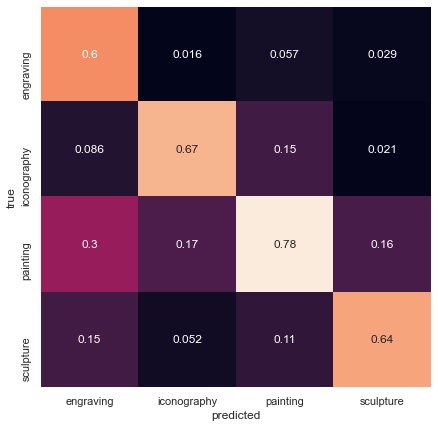

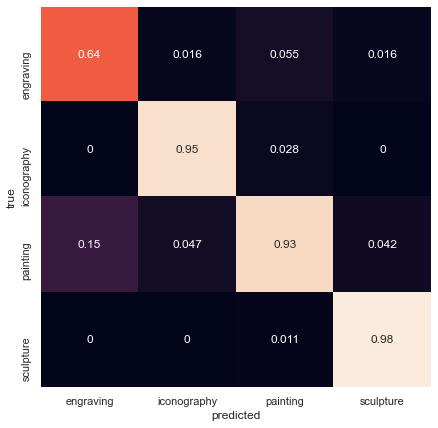

0.9164345403899722


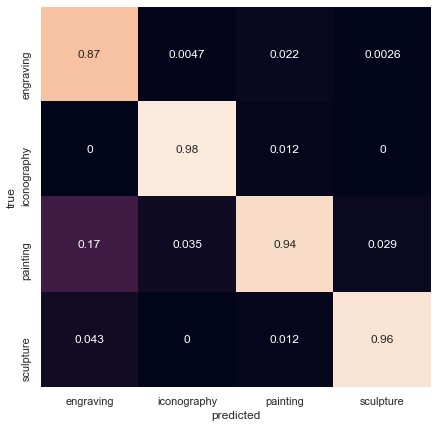

0.943732590529248


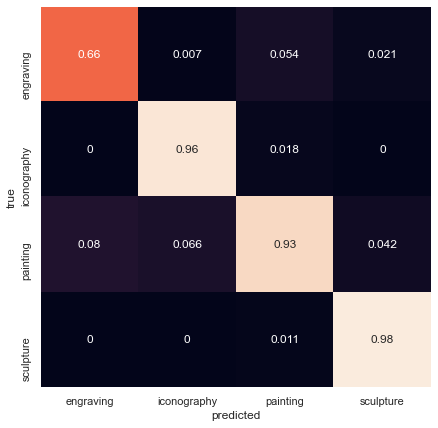

0.9242339832869081


In [17]:
final_results = [test_model(simplenet, test_loader, 'simplenet_cmat').item()]
for model_name in ['resnet', 'alexnet', 'vgg']:
    model, input_size = initialize_model(model_name, len(CLASSES), True, use_pretrained=True)
    model.load_state_dict(torch.load(model_name + '.pth'))
    final_results.append(test_model(model.to(DEVICE), test_loader, model_name + '_cmat').item())
    print(final_results[-1])

In [78]:
from PIL import Image

img = Image.open("data\painting\Alfred_Sisley_2.jpg")
model.eval()
output = model(transforms(img.convert("RGB")).view(1, 3, 224, 224).to(DEVICE)).cpu()
nn.Softmax(dim=1)(output)

tensor([[1.6426e-05, 1.5114e-10, 9.9998e-01, 4.3670e-07]],
       grad_fn=<SoftmaxBackward>)

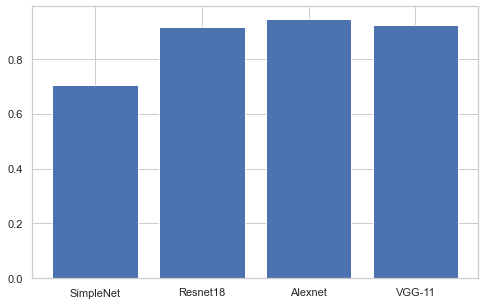

In [42]:
plt.figure(figsize=(8,5))
plt.bar(['SimpleNet', 'Resnet18', 'Alexnet', 'VGG-11'], final_results)
plt.gcf().savefig('final_results')
plt.show()

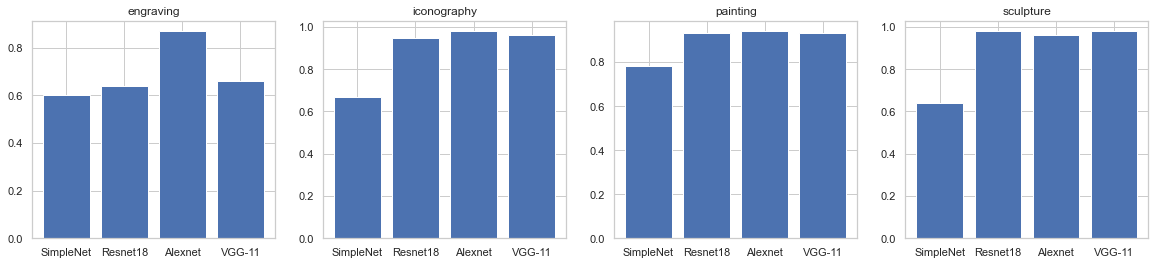

In [41]:
results = {
    'engraving': [0.6, 0.64, 0.87, 0.66],
    'iconography': [0.67, 0.95, 0.98, 0.96],
    'painting': [0.78, 0.93, 0.94, 0.93],
    'sculpture': [0.64, 0.98, 0.96, 0.98]
}
plt.figure(figsize=(20,4))
for key, i in zip(results.keys(), range(1,5)):
    plt.subplot(1,4,i)
    plt.bar(['SimpleNet', 'Resnet18', 'Alexnet', 'VGG-11'], results[key])
    plt.title(key)
plt.gcf().savefig('results')